## Imports

In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt

## Device choice

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data preparation

In [3]:
def get_mean_std(dataset):
    mean = 0
    squared_mean = 0

    for i in range(len(dataset)):
        x = dataset[i][0].reshape(1, -1)
        mean += x.mean()
        squared_mean += (x**2).mean()

    mean /= len(dataset)
    squared_mean /= len(dataset)

    std = (squared_mean - mean ** 2) ** 0.5
    
    return mean, std

# Pass this as a transform to dataset
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
train_mnist = torchvision.datasets.MNIST('/files/', 
                                         train=True,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                         ]),
                                         download=True)

test_mnist = torchvision.datasets.MNIST('/files/', 
                                        train=False, 
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                        ]),
                                        download=True)

mean, std = get_mean_std(train_mnist)

train_mnist = torchvision.datasets.MNIST('/files/', 
                                         train=True,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((mean,), (std,)),
                                             AddGaussianNoise(0., 1.),
                                         ]),
                                         download=True)

test_mnist = torchvision.datasets.MNIST('/files/', 
                                        train=False, 
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((mean,), (std,)),
                                        ]),
                                        download=True)

## Model

### Training step function creator

In [5]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        
        y_hat = model(x)
        
        loss = loss_fn(y_hat, y)
        loss.backward()
        
        accuracy = (y_hat.argmax(axis=1) == y).float().mean().item()
        
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item(), accuracy
    
    return train_step

### Model definition

In [6]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    
    torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(5, 5)),
    torch.nn.Dropout2d(),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    
    torch.nn.Flatten(),
    
    torch.nn.Linear(320, 50),
    torch.nn.ReLU(),
    
    torch.nn.Linear(50, 10),
    torch.nn.LogSoftmax(),
).to(device)

### Hyperparameters definition

In [7]:
nb_epochs = 10

lr = 1e-2
momentum = 0.5
loss_reduction='mean'

train_batch_size = 60
test_batch_size = 120

log_interval = 100

train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=test_batch_size, shuffle=True)

# loss_fn = torch.nn.CrossEntropyLoss(reduction=loss_reduction)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_step = make_train_step(model, loss_fn, optimizer)

## Training & Testing

In [8]:
def train(train_step_fn, train_loader, train_losses, train_accuracies, train_counter, epoch, log_interval):
    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        loss, accuracy = train_step_fn(x_train, y_train)
        
        if batch_idx % log_interval == 0:
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            train_counter.append((epoch-1) * len(train_loader.dataset) + batch_idx * len(x_train))
            
            print(f"Training epoch #{epoch} ({batch_idx * train_batch_size + len(x_train)}"\
                  f"/ {len(train_loader.dataset)}) ({(100. * batch_idx / len(train_loader)):.0f}%)"\
                  f" - Loss = {loss:.6f} - Accurary = {(100 * accuracy):.2f}%")
    print("")
            

def test(test_loader, test_losses, test_accuracies, epoch):
    test_loss = 0
    test_accu = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            
            model.eval()

            y_hat = model(x_test)
            
            test_loss += loss_fn(y_hat, y_test).item()
            test_accu += (y_hat.argmax(axis=1) == y_test).float().mean().item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        test_accu /= len(test_loader)
        test_accuracies.append(test_accu)
        
        if epoch == 0:
            print(f"Test - No training yet - Avg. loss = {test_loss:.6f} - Avg. Accu = {(100 * test_accu):.2f}%")
        else:
            print(f"Test epoch #{epoch} - Avg. loss = {test_loss:.6f} - Avg. Accu = {(100 * test_accu):.2f}%")
            
        print("---------------------------------------------\n\n")

In [9]:
train_losses = []
train_accuracies = []
train_counter = []

test_losses = []
test_accuracies = []
test_counter = []

last_epoch = 1

In [10]:
# If model hasn't been trained yet, do a test (as a reference)
if last_epoch == 1:
    test(test_loader, test_losses, test_accuracies, 0)
    test_counter.append(0)

for epoch in range(last_epoch, last_epoch + nb_epochs):
    # Train
    train(train_step, train_loader, train_losses, train_accuracies, train_counter, epoch, log_interval)
    
    # Test
    test(test_loader, test_losses, test_accuracies, epoch)
    test_counter.append(epoch * len(train_loader.dataset))
            
last_epoch = epoch

D:\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test - No training yet - Avg. loss = 2.315295 - Avg. Accu = 10.10%
---------------------------------------------


Training epoch #1 (60/ 60000) (0%) - Loss = 2.394593 - Accurary = 5.00%
Training epoch #1 (6060/ 60000) (10%) - Loss = 1.816393 - Accurary = 36.67%
Training epoch #1 (12060/ 60000) (20%) - Loss = 0.741652 - Accurary = 85.00%
Training epoch #1 (18060/ 60000) (30%) - Loss = 0.802587 - Accurary = 83.33%
Training epoch #1 (24060/ 60000) (40%) - Loss = 0.450634 - Accurary = 85.00%
Training epoch #1 (30060/ 60000) (50%) - Loss = 0.458764 - Accurary = 91.67%
Training epoch #1 (36060/ 60000) (60%) - Loss = 0.335620 - Accurary = 91.67%
Training epoch #1 (42060/ 60000) (70%) - Loss = 0.271896 - Accurary = 95.00%
Training epoch #1 (48060/ 60000) (80%) - Loss = 0.623138 - Accurary = 80.00%
Training epoch #1 (54060/ 60000) (90%) - Loss = 0.507188 - Accurary = 90.00%

Test epoch #1 - Avg. loss = 0.178963 - Avg. Accu = 94.49%
---------------------------------------------


Training epoch

Training epoch #10 (18060/ 60000) (30%) - Loss = 0.051447 - Accurary = 96.67%
Training epoch #10 (24060/ 60000) (40%) - Loss = 0.028145 - Accurary = 100.00%
Training epoch #10 (30060/ 60000) (50%) - Loss = 0.043949 - Accurary = 100.00%
Training epoch #10 (36060/ 60000) (60%) - Loss = 0.169804 - Accurary = 95.00%
Training epoch #10 (42060/ 60000) (70%) - Loss = 0.095358 - Accurary = 96.67%
Training epoch #10 (48060/ 60000) (80%) - Loss = 0.075059 - Accurary = 96.67%
Training epoch #10 (54060/ 60000) (90%) - Loss = 0.158249 - Accurary = 90.00%

Test epoch #10 - Avg. loss = 0.045457 - Avg. Accu = 98.41%
---------------------------------------------




## Plots

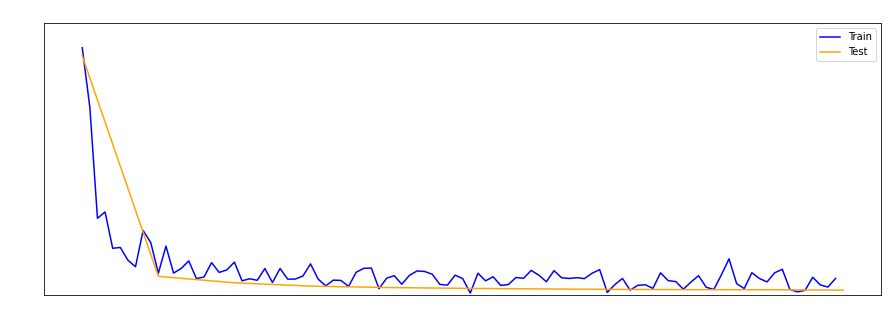

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(train_counter, train_losses, color='blue', label='Train')
plt.plot(test_counter, test_losses, color='orange', label='Test')

plt.setp(plt.title("Train/Test loss per # of images trained on"), color='white')
plt.setp(plt.xlabel("# of images trained on"), color='white')
plt.setp(plt.ylabel("NLLLoss"), color='white')

plt.legend(loc='upper right')

plt.ylim([0, max(train_losses + test_losses) * 1.1])

plt.tick_params(colors='white')

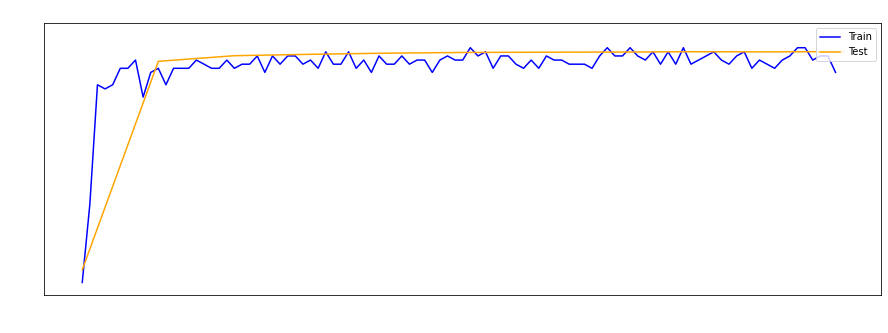

In [17]:
plt.figure(figsize=(15, 5))

plt.plot(train_counter, train_accuracies, color='blue', label='Train')
plt.plot(test_counter, test_accuracies, color='orange', label='Test')

plt.setp(plt.title("Train/Test accuracy per # of images trained on"), color='white')
plt.setp(plt.xlabel("# of images trained on"), color='white')
plt.setp(plt.ylabel("Accuracy"), color='white')

plt.legend(loc='upper right')

plt.ylim([0, max(train_accuracies + test_accuracies) * 1.1])

plt.tick_params(colors='white')

In [13]:
import os 
path = os.getcwd() + '\\mnist_classifier_model.pth'
torch.save(model.state_dict(), path)

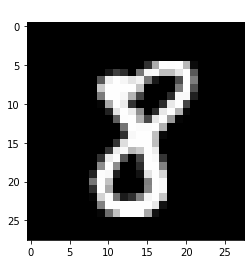

In [78]:
with torch.no_grad():
    model.eval()
    it = iter(test_loader)
    nx = next(it)
    
    img, label = nx
    img = img[0].to(device)
    label = label[0].item()

    preds = model(img.unsqueeze(1))
    pred = np.argmax(preds[0].cpu()).item()
    
    plt.imshow(img[0].cpu(), cmap="gray")
    title = f"True: {label} | Pred: {pred}"
    plt.setp(plt.title(title), color="w")
    